## Implementing the A* Algorithm

### Objective:
Implement the A* Algorithm and use it to solve the 8-Puzzle Problem. Code should be able to read an input file named "astar_in.txt" that decribes the configurations for the start and goal states, as shown in the image of the txt file below.
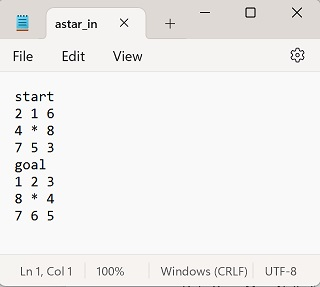
### Notes:
<ul>
    <li>Use Jupyter notebook to implement the A* Algorithm following the pseudocode described in slide 21 of Lecture 3B. </li>
    <li>Output the sequence of states from start to goal for the following heuristic functions:</li>
    <ol>
        <li>Number of Tiles in the Wrong Position</li>
        <li>Manhattan Distance</li>
        <li>Nilsson's Sequence Score</li>
    </ol>
</ul>
<ul>
    <li>For each step, output the values of f(n), g(n), h(n), and, if applicable P(n), S(n). The search cost (in number of nodes generated) for each heuristic function should be outputted as well.</li>
</ul>

In [1]:
from copy import deepcopy
import heapq
import time
import pandas as pd
import numpy as np
import random as rand

In [2]:
filename = 'data.txt'
file = pd.read_csv(filename, sep=' ', header=None, skiprows=[0,4])
root_node = np.array(file[:3], dtype=str)
goal_node = np.array(file[3:], dtype=str)

In [3]:
class puzzle8:

    def __init__(self, current, parent=None, goal=goal_node, g=0, h=0, f=0, p=0, s=0):
        self.current = current
        self.parent = parent
        self.goal = goal
        self.g = g
        self.h = h
        self.f = f
        self.p = p
        self.s = s

    def hcost_wrongpos(self):
        '''
        heuristic fuction that counts the number of tiles in the wrong position
        '''
        if np.where(self.current == "*") == np.where(self.goal == "*"):
            return np.count_nonzero(self.current != self.goal)
        else:
            return np.count_nonzero(self.current != self.goal) - 1
    
    def hcost_manhattan(self):
        '''
        heuristic fuction that calculates manhattan distance
        manhattan distance = sum of the horizontal and vertical distances of a misplaced tile from its goal position
        '''
        h = 0
        for i in range(3):
            for j in range(3):
                curr = self.current[i][j]
                if curr != '*':
                    goal = np.where(self.goal == self.current[i][j])
                    row, col = (goal[0].astype(int).item(), goal[1].astype(int).item())
                    h += abs(row-i) + abs(col-j)
                else: continue
        return h
    
    def hcost_nilsson(self):
        '''
        heuristic function that calculates nilsson's sequence score
        nilsson's sequence score = P(n) + 3 S(n)
            where P(n) = manhattan distance of each tile from its goal position
            and S(n) = in a clockwise direction, 
                       2 is given to every non-central square tile NOT followed by its proper successor,
                       0 is given to every non-central square tile followed by its proper successor,
                       1 is given to the central square
        reference: https://stackoverflow.com/questions/10584788/can-anyone-explain-nilssons-sequence-score-in-8-puzzle-more-clearly/10607141#10607141
        '''
        reference = np.array([[0,1,2],[7,8,3],[6,5,4]])
        p = self.hcost_manhattan()
        s = 0
        for i in range(3):
            for j in range(3):
                if self.current[i][j] == '*':
                    continue
                else:
                    curr_element = int(self.current[i][j])
                    if curr_element == 8:
                        nxt_element = '1'
                    else:
                        nxt_element = str(curr_element + 1)
                nxt_row, nxt_col = np.where(self.current == nxt_element)
                nxt_ref = reference[nxt_row.item()][nxt_col.item()]
                curr_ref = reference[i][j]
                if curr_ref == 8:
                    s += 1
                elif nxt_ref != (curr_ref + 1) % 8:
                    s += 2
        h = p + 3*s
        return h, p, s
    
    def hcost_method(self, method):
        '''
        sets heuristic function to be used
        '''
        if method == 'Wrong Position':
            h, p, s = self.hcost_wrongpos(), 0, 0
            return h, p, s
        elif method == 'Manhattan':
            h, p, s = self.hcost_manhattan(), 0, 0
            return h, p, s
        elif method == 'Nilsson':
            h, p, s = self.hcost_nilsson()
            return h, p, s
        
    def expansion(self):
        '''
        expands current node, returns its valid successors or an empty list if there is no valid successor
        '''
        successors = []
        i = np.where(self.current == "*")[0].item()
        j = np.where(self.current == "*")[1].item()
        
        actions = [(i+1,j), (i-1,j), (i,j+1), (i,j-1)]
        
        for act in actions:
            if 0 <= act[0] < 3 and 0 <= act[1] < 3:
                successor = deepcopy(self.current)
                successor[i][j] = successor[act[0]][act[1]]
                successor[act[0]][act[1]] = "*"
                successors.append(puzzle8(current=successor, parent=self.current))
            else: continue   
                
        return successors
               
    def goal_test(self):
        '''
        checks if current node is the goal node
        '''
        return np.array_equal(self.current, self.goal)
    
    def trace_path(self):
        '''
        retraces path of current node by appending successive parent nodes and returns the reverse of that path
        '''
        path = []
        state = self
        while state:
            path.append(state)
            state = state.parent
        path.reverse()
        return path
    

In [4]:
def fmin_list(openlist):
    '''
    returns a list of nodes with the minimum fcost
    '''
    sample_state = min(openlist, key = lambda state:state.f)
    fmin_cnt = sum(1 for state in openlist if state.f == sample_state.f)
    fmin_list = heapq.nsmallest(fmin_cnt, openlist, key=lambda x:x.f)
    return fmin_list

def astar_search(method, root=root_node):
    '''
    main A* search algorithm
    '''
    init_time = time.time() #Initialize search cost in terms of processing time
    search_cost = 0 #Initialize search cost in terms of number of nodes that will be generated
    search_expansion_use = 0 #Initialize number of times expansion that will be used
    
    openlist = [] #Initialize open list for nodes ready for expansion
    closedlist = [] #Initialize closed list for expanded nodes
    
    #Compute f-cost of start node and put start node in open list
    init_state = puzzle8(current=root)
    init_state.h, init_state.p, init_state.s = init_state.hcost_method(method) 
    init_state.f = init_state.g + init_state.h
    openlist.append(init_state)
    
    while openlist: #While loop runs ONLY if open list is NOT empty. Otherwise, value error is raised at the end.
        
        #Resolve ties for minimal f-cost arbitrarily but favor goal node
        fminlist = fmin_list(openlist)
        for state in fminlist:
            #Exit with solution path (and costs) if node with the lowest f-cost is the goal node
            if state.goal_test():
                end_time = time.time()
                tot_time = round(end_time - init_time, 2)
                return state.trace_path(), search_cost, search_expansion_use, tot_time
        curr_state = rand.choice(fminlist)
        
        #Remove the arbitrarily chosen node with the lowest f-cost from open list and put it in closed list
        curr_state_index = openlist.index(curr_state)
        openlist.pop(curr_state_index)
        closedlist.append(curr_state)
        
        #Expand node and list its successors. Return empty list if node has no successor.
        successorlist = curr_state.expansion()
        
        #Add 1 to usage of expansion. Add the number of successors generated to search cost
        search_expansion_use += 1
        search_cost += len(successorlist)
        
        for successor in successorlist: #For loop runs ONLY if successor list is NOT empty. Otherwise, it returns to while loop.
            
            successor.parent = curr_state #Set parent node of successor
            
            #Compute g-cost, h-cost, (p-cost, s-cost,) and f-cost of successor
            successor.g = len(successor.trace_path())-1
            successor.h, successor.p, successor.s = successor.hcost_method(method)
            successor.f = successor.g + successor.h
            
            #Check the later eligibility of successor to be added in the open list at the end 
            status_open = True
            status_closed = True
            
            #Run through nodes in open list to check if successor is in open list
            for index, state in enumerate(openlist):
                #Associate successor to its counterpart in open list and remove later eligibility of successor
                #if it is in open list and has lower f-cost than its counterpart
                if np.array_equal(state.current, successor.current) and state.f > successor.f:
                    status_open = False
                    openlist[index] = successor
                    break
                #Remove later eligibilty of successor 
                #if it is in open list but does not have a lower f-cost than its counterpart
                elif np.array_equal(state.current, successor.current) and state.f <= successor.f:
                    status_open = False
                    break
                #Retain later eligibility of successor if it is not in open list
                else:
                    status_open = True
                    continue
                    
            #Run through nodes in closed list to check if successor is in closed list
            for state in closedlist:
                #Remove counterpart of successor in closed list, add successor in open list and remove later eligibility of successor
                #if it is in closed list and has lower f-cost than its counterpart
                if np.array_equal(state.current, successor.current) and state.f > successor.f:
                    status_closed = False
                    closedlist.pop(state)
                    openlist.append(successor)
                    break
                #Remove later eligibilty  of successor 
                #if it is in closed list but does not have a lower f-cost than its counterpart
                elif np.array_equal(state.current, successor.current) and state.f <= successor.f:
                    status_closed = False
                    break
                #Retain later eligibility of successor if it is not in closed list
                else:
                    status_closed = True
                    continue
                    
            #Has eligibility to be added in open list 
            if status_open == True and status_closed == True:
                openlist.append(successor)
            else: continue 
                
    raise ValueError('FAILURE. Open list is empty. No solution is found.') # Exit with failure if open list is empty

In [5]:
path, search_cost, search_expansion_use, tot_time = astar_search(method = 'Wrong Position')
print(f'Expansion Usage: {search_expansion_use}\nSearch Cost (in generated nodes): {search_cost}')
print(f'Search Cost (in processing time): {tot_time} s\nNumber of Moves (from start to goal): {len(path)-1}\n')
for node in path:
    print(f'g(n): {node.g} | h(n): {node.h} | f(n): {node.f}\n{node.current}\n')

Expansion Usage: 1522
Search Cost (in generated nodes): 4190
Search Cost (in processing time): 47.1 s
Number of Moves (from start to goal): 18

g(n): 0 | h(n): 7 | f(n): 7
[['2' '1' '6']
 ['4' '*' '8']
 ['7' '5' '3']]

g(n): 1 | h(n): 7 | f(n): 8
[['2' '*' '6']
 ['4' '1' '8']
 ['7' '5' '3']]

g(n): 2 | h(n): 6 | f(n): 8
[['*' '2' '6']
 ['4' '1' '8']
 ['7' '5' '3']]

g(n): 3 | h(n): 6 | f(n): 9
[['4' '2' '6']
 ['*' '1' '8']
 ['7' '5' '3']]

g(n): 4 | h(n): 6 | f(n): 10
[['4' '2' '6']
 ['1' '*' '8']
 ['7' '5' '3']]

g(n): 5 | h(n): 6 | f(n): 11
[['4' '2' '6']
 ['1' '8' '*']
 ['7' '5' '3']]

g(n): 6 | h(n): 6 | f(n): 12
[['4' '2' '*']
 ['1' '8' '6']
 ['7' '5' '3']]

g(n): 7 | h(n): 7 | f(n): 14
[['4' '*' '2']
 ['1' '8' '6']
 ['7' '5' '3']]

g(n): 8 | h(n): 7 | f(n): 15
[['*' '4' '2']
 ['1' '8' '6']
 ['7' '5' '3']]

g(n): 9 | h(n): 6 | f(n): 15
[['1' '4' '2']
 ['*' '8' '6']
 ['7' '5' '3']]

g(n): 10 | h(n): 5 | f(n): 15
[['1' '4' '2']
 ['8' '*' '6']
 ['7' '5' '3']]

g(n): 11 | h(n): 5 | f(

In [6]:
path, search_cost, search_expansion_use, tot_time = astar_search(method = 'Manhattan')
print(f'Expansion Usage: {search_expansion_use}\nSearch Cost (in generated nodes): {search_cost}')
print(f'Search Cost (in processing time): {tot_time} s\nNumber of Moves (from start to goal): {len(path)-1}\n')
for node in path:
    print(f'g(n): {node.g} | h(n): {node.h} | f(n): {node.f}\n{node.current}\n')

Expansion Usage: 203
Search Cost (in generated nodes): 551
Search Cost (in processing time): 0.96 s
Number of Moves (from start to goal): 18

g(n): 0 | h(n): 12 | f(n): 12
[['2' '1' '6']
 ['4' '*' '8']
 ['7' '5' '3']]

g(n): 1 | h(n): 11 | f(n): 12
[['2' '1' '6']
 ['4' '8' '*']
 ['7' '5' '3']]

g(n): 2 | h(n): 10 | f(n): 12
[['2' '1' '*']
 ['4' '8' '6']
 ['7' '5' '3']]

g(n): 3 | h(n): 11 | f(n): 14
[['2' '*' '1']
 ['4' '8' '6']
 ['7' '5' '3']]

g(n): 4 | h(n): 12 | f(n): 16
[['2' '8' '1']
 ['4' '*' '6']
 ['7' '5' '3']]

g(n): 5 | h(n): 11 | f(n): 16
[['2' '8' '1']
 ['4' '6' '*']
 ['7' '5' '3']]

g(n): 6 | h(n): 10 | f(n): 16
[['2' '8' '1']
 ['4' '6' '3']
 ['7' '5' '*']]

g(n): 7 | h(n): 9 | f(n): 16
[['2' '8' '1']
 ['4' '6' '3']
 ['7' '*' '5']]

g(n): 8 | h(n): 8 | f(n): 16
[['2' '8' '1']
 ['4' '*' '3']
 ['7' '6' '5']]

g(n): 9 | h(n): 7 | f(n): 16
[['2' '8' '1']
 ['*' '4' '3']
 ['7' '6' '5']]

g(n): 10 | h(n): 8 | f(n): 18
[['*' '8' '1']
 ['2' '4' '3']
 ['7' '6' '5']]

g(n): 11 | h(n

In [7]:
path, search_cost, search_expansion_use, tot_time = astar_search(method = 'Nilsson')
print(f'Expansion Usage: {search_expansion_use}\nSearch Cost (in generated nodes): {search_cost}')
print(f'Search Cost (in processing time): {tot_time} s\nNumber of Moves (from start to goal): {len(path)-1}\n')
for node in path:
    print(f'g(n): {node.g} | h(n): {node.h} | P(n): {node.p} | S(n): {node.s} | f(n): {node.f}\n{node.current}\n')

Expansion Usage: 28
Search Cost (in generated nodes): 79
Search Cost (in processing time): 0.07 s
Number of Moves (from start to goal): 18

g(n): 0 | h(n): 60 | P(n): 12 | S(n): 16 | f(n): 60
[['2' '1' '6']
 ['4' '*' '8']
 ['7' '5' '3']]

g(n): 1 | h(n): 56 | P(n): 11 | S(n): 15 | f(n): 57
[['2' '1' '6']
 ['4' '8' '*']
 ['7' '5' '3']]

g(n): 2 | h(n): 55 | P(n): 10 | S(n): 15 | f(n): 57
[['2' '1' '*']
 ['4' '8' '6']
 ['7' '5' '3']]

g(n): 3 | h(n): 56 | P(n): 11 | S(n): 15 | f(n): 59
[['2' '*' '1']
 ['4' '8' '6']
 ['7' '5' '3']]

g(n): 4 | h(n): 54 | P(n): 12 | S(n): 14 | f(n): 58
[['2' '8' '1']
 ['4' '*' '6']
 ['7' '5' '3']]

g(n): 5 | h(n): 50 | P(n): 11 | S(n): 13 | f(n): 55
[['2' '8' '1']
 ['4' '6' '*']
 ['7' '5' '3']]

g(n): 6 | h(n): 49 | P(n): 10 | S(n): 13 | f(n): 55
[['2' '8' '1']
 ['4' '6' '3']
 ['7' '5' '*']]

g(n): 7 | h(n): 48 | P(n): 9 | S(n): 13 | f(n): 55
[['2' '8' '1']
 ['4' '6' '3']
 ['7' '*' '5']]

g(n): 8 | h(n): 38 | P(n): 8 | S(n): 10 | f(n): 46
[['2' '8' '1']
 ['